In [ ]:
'''
working

outline
    DONE v 0.1 langgraph chatbot based implementation
        default prompt and purpose
        implements a minimal example based on that prompt
        asks for user feedback ends
    DONE v 0.2 add a second LLM as an editor
        second LLM as an editor
    v 0.3 add LLM editor and critic
        add edge from editor to critic
        conditional edge from critic to writer if doesn't like. pass in the editor's output
        conditional edge from writer to user if needs more help

    v 0.4 context, and memory, streaming

    grab from back log
        langsmith
        test stopping and stepping through the state and graph
        then images

backlog
    different naems for the assistants
    practice steping through the state and graph and seeing the issues
    improved prompt templates
    improved prompts with n shot context
    langsmith
    incorporate images
        find something cheap for first
    better interface
        notebook -> gradio/langchain default -> node.js
    cicd

'''

In [ ]:
# _set_env("LANGSMITH_API_KEY")
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

### v0.1 Langraph chatbot
* https://langchain-ai.github.io/langgraph/tutorials/introduction/#setup

In [1]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

In [9]:
from typing import Annotated

#from langchain_anthropic import ChatAnthropic
from langchain_openai import OpenAI, ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


#llm = ChatAnthropic(model="claude-3-haiku-20240307")
#llm = OpenAI(model_name=)
llm = ChatOpenAI(model_name="gpt-3.5-turbo")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
graph = graph_builder.compile()

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

Assistant: Hello! How can I assist you today?
Assistant: The capital of Nova Scotia is Halifax.
Goodbye!


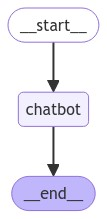

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### v0.2 Add the editor

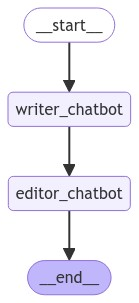

In [23]:
from typing import Annotated

#from langchain_anthropic import ChatAnthropic
from langchain_openai import OpenAI, ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


#llm = ChatAnthropic(model="claude-3-haiku-20240307")
#llm = OpenAI(model_name=)
writer_llm = ChatOpenAI(model_name="gpt-3.5-turbo")
editor_llm = ChatOpenAI(model_name="gpt-3.5-turbo")

# Define the prompts
writer_prompt = '''
    You are a creative writer. Please write a short story for children under five years old based on the following input.
    The story should be no more than 10 sentences.
    '''

editor_prompt = '''
    You are an editor. Please review and edit the following story for clarity, brevity, and grammar.
    The story is for children under five years old. The story should be no more than 10 sentences.
    '''


def writer_chatbot(state: State):
    state["messages"].append(("system", writer_prompt))

    response = writer_llm.invoke(state["messages"])

    state["messages"].append(response)

    return state
    

def editor_chatbot(state: State):
    state["messages"].append(("system", editor_prompt))

    response = editor_llm.invoke(state["messages"])

    state["messages"].append(response)
    return state
    


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("writer_chatbot", writer_chatbot)
graph_builder.add_node("editor_chatbot", editor_chatbot)

graph_builder.set_entry_point("writer_chatbot")
graph_builder.set_finish_point("editor_chatbot")

graph_builder.add_edge("writer_chatbot", "editor_chatbot")
#graph_builder.add_edge("editor_chatbot", "writer_chatbot")


graph = graph_builder.compile()


from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [40]:
import pprint

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        #for value in event.values():
        for key, value in event.items():
            #print("Assistant:", value["messages"][-1].content)
            message_str = f'''{key}: {value["messages"][-1].content}'''
            pprint.pprint(message_str)


('writer_chatbot: Once upon a time, in a cozy little pond, there lived a happy '
 'green frog named Freddy. Freddy loved to hop around and play all day long. '
 'One sunny morning, he met a friendly duck named Daisy. They quickly became '
 'best friends and spent their days swimming and exploring together. One day, '
 'a big storm came and flooded the pond. Freddy and Daisy had to work together '
 'to find a safe place to hide. They found a hollow log and huddled together '
 'until the storm passed. After the storm, the sun came out and the pond was '
 'even more beautiful than before. Freddy and Daisy were grateful for each '
 "other's friendship and continued to have fun adventures together. And from "
 'that day on, they knew that no matter what challenges came their way, they '
 'could always count on each other. The end.')
('editor_chatbot: Once upon a time, in a cozy pond, there lived a happy green '
 'frog named Freddy. Freddy loved to hop and play all day. One sunny morning, '


In [39]:
event.items()

dict_items([('editor_chatbot', {'messages': [HumanMessage(content='write me a story about a frog', id='4c9d4bca-b6d0-4444-9762-1e1927d68cb7'), SystemMessage(content='\n    You are a creative writer. Please write a short story for children under five years old based on the following input.\n    The story should be no more than 10 sentences.\n    ', id='4ce6df95-29c1-406c-8efc-e425694a8ec3'), AIMessage(content='Once upon a time, in a peaceful pond, there lived a little green frog named Freddy. Freddy loved to hop around and explore the water lilies and reeds. One day, while playing by the shore, he saw a colorful butterfly fluttering by. "Hello, little butterfly!" Freddy croaked happily. The butterfly landed on Freddy\'s nose and they became fast friends. They played together all day, chasing each other around the pond. As the sun began to set, the butterfly had to leave to find a place to sleep for the night. But before leaving, he promised to come back and visit Freddy the next day. Fr

In [33]:
dir(value)

['__class__',
 '__class_getitem__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__ior__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__or__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__ror__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'clear',
 'copy',
 'fromkeys',
 'get',
 'items',
 'keys',
 'pop',
 'popitem',
 'setdefault',
 'update',
 'values']

In [38]:
event.keys()

dict_keys(['editor_chatbot'])

In [37]:
dir(event)

['__add__',
 '__class__',
 '__class_getitem__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__ior__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__or__',
 '__orig_bases__',
 '__parameters__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__ror__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_is_protocol',
 'clear',
 'copy',
 'fromkeys',
 'get',
 'items',
 'keys',
 'pop',
 'popitem',
 'setdefault',
 'update',
 'values']

In [30]:
import pprint
message_str = f'''Assistant: {value["messages"][-1].content}'''
pprint.pprint(message_str)

('Assistant: In a cozy pond, there was a little frog named Freddy. Freddy '
 'loved to hop and play in the water. One day, he met a colorful butterfly '
 'named Bella. They became fast friends and played all day. When the sun began '
 'to set, Bella had to go find a place to sleep. Freddy smiled and watched her '
 'fly away, excited for their next adventure. As the moon rose, Freddy fell '
 'asleep, dreaming of his new friend. The end.')
